In [11]:
import torch
from torch import nn
from d2l import torch as d2l
import random
import numpy as np


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [19]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2: # Linear Layer
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.-momentum) * mean
        moving_var = momentum * moving_var + (1.-momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [13]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
            
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta,
                                                          self.moving_mean, self.moving_var,
                                                          eps=1e-5, momentum=0.9)
        return Y

In [23]:
class BatchNormFixed(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
            
        self.gamma = torch.ones(shape)
        self.beta = torch.zeros(shape)
        
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
            self.gamma = self.gamma.to(X.device)
            self.beta = self.beta.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta,
                                                          self.moving_mean, self.moving_var,
                                                          eps=1e-5, momentum=0.9)
        return Y

In [14]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

In [24]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNormFixed(6, num_dims=4),
                    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNormFixed(16, num_dims=4),
                    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNormFixed(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNormFixed(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

loss 0.264, train acc 0.903, test acc 0.810
91332.9 examples/sec on cuda:0


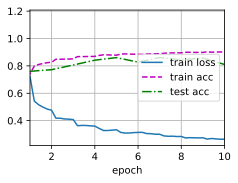

In [15]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.363, train acc 0.869, test acc 0.768
97105.4 examples/sec on cuda:0


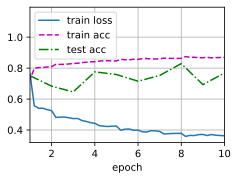

In [26]:
# Fixed gamma, beta
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [6]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([3.2001, 1.6046, 2.3669, 3.2280, 2.2077, 4.2439], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-3.5949, -0.6294, -1.9908, -1.0839, -2.2715,  2.4578], device='cuda:0',
        grad_fn=<ViewBackward>))

In [9]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
                    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
                    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(256, 120), nn.Dropout(0.5), nn.BatchNorm1d(120),
                    nn.Sigmoid(), nn.Linear(120, 84), nn.Dropout(0.5), nn.BatchNorm1d(84),
                    nn.Sigmoid(), nn.Linear(84, 10))

loss 0.379, train acc 0.868, test acc 0.822
137177.6 examples/sec on cuda:0


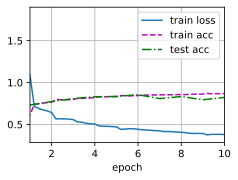

In [10]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())